<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/%EA%B3%BC%EC%A0%9C/%ED%8A%B9%EC%84%B1_feature_%ED%99%95%EC%9D%B8_%EC%8B%A4%ED%97%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 드라이브 파일 train : https://drive.google.com/file/d/1F6Otr01l-sUUR_1AdTM925tAGDE_L--t/view?usp=drive_link
# test : https://drive.google.com/file/d/13lNIGs3wsD0mZF4OauV4GhZQHniNjK6d/view?usp=drive_link
# sub misson : https://drive.google.com/file/d/1RLdtGa4N62Q_5XFp0OOGTR5iVFObxjme/view?usp=drive_link

In [ ]:
!gdown https://drive.google.com/uc?id=1F6Otr01l-sUUR_1AdTM925tAGDE_L--t
!gdown https://drive.google.com/uc?id=13lNIGs3wsD0mZF4OauV4GhZQHniNjK6d
!pip install catboost
!pip install optuna
!pip install -U mlflow optuna

In [ ]:
import os, math
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import missingno as msno

# scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error

# 분류 모델
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostRegressor

import warnings

# Auto ML
import optuna

warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [ ]:
df = train.copy()

In [ ]:
# one = ['child_num','income_total','DAYS_BIRTH','DAYS_EMPLOYED','work_phone','phone','email','family_size','gender','car','reality','income_type','edu_type','family_type','house_type','occyp_type']
# no = ['child_num','income_total','DAYS_EMPLOYED','phone','family_size']

### 필요없는 열 삭제

In [ ]:
del df['FLAG_MOBIL']
del test['FLAG_MOBIL']

### 특성값 확인

In [ ]:
# NAN값 Unknown으로 변경
df['occyp_type'] = df['occyp_type'].fillna("Unknown")
test['occyp_type'] = test['occyp_type'].fillna("Unknown")

In [ ]:
# # 모든 object 열을 더해보자
# object_columns = df.select_dtypes(include='object').columns
# df['ID'] = df[object_columns].astype(str).apply(lambda x: '_'.join(x), axis=1) >> 71.7 (RF)

In [ ]:
add_columns = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
       'house_type', 'occyp_type', 'work_phone', 'email', 'DAYS_BIRTH']
df['ID'] = df[add_columns].astype(str).apply(lambda x: '_'.join(x), axis=1)
test['ID'] = test[add_columns].astype(str).apply(lambda x: '_'.join(x), axis=1)

In [ ]:
# 일한 일수 양수는 일하지 않았다고 보고 0.0000000001으로 변경
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: 0.0000000001 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(lambda x: 0.0000000001 if x > 0 else x)

In [ ]:
# 음수값 양수값으로 변경

features = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
for f in features:
    df[f] = df[f].abs()
    test[f] = test[f].abs()

In [ ]:
# 안쓰면 71.3 ↓ 0.4
# 일 안한 날 생성
df["No_work"] = df["DAYS_BIRTH"] - df['DAYS_EMPLOYED']
test["No_work"] = test["DAYS_BIRTH"] - test['DAYS_EMPLOYED']

# 연으로 변경
df["BIRTH_y"] = df["DAYS_BIRTH"] / 365
df['EMPLOYED_y'] = df['DAYS_EMPLOYED'] / 365
df["No_work_y"] = df["No_work"] / 365
test["BIRTH_y"] = test["DAYS_BIRTH"] / 365
test['EMPLOYED_y'] = test['DAYS_EMPLOYED'] / 365
test["No_work_y"] = test["No_work"] / 365

# 달로 변경
df["BIRTH_m"] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
df['EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
df["No_work_m"] = np.floor(df['No_work'] / 30) - ((np.floor(df['No_work'] / 30) / 12).astype(int) * 12)
test["BIRTH_m"] = np.floor(test['DAYS_BIRTH'] / 30) - ((np.floor(test['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
test['EMPLOYED_m'] = np.floor(test['DAYS_EMPLOYED'] / 30) - ((np.floor(test['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
test["No_work_m"] = np.floor(test['No_work'] / 30) - ((np.floor(test['No_work'] / 30) / 12).astype(int) * 12)

# 주로 변경
df["BIRTH_w"] =  np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)
df["EMPLOYED_w"] =  np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)
df["No_work_w"] =  np.floor(df['No_work'] / 7) - ((np.floor(df['No_work'] / 7) / 4).astype(int) * 4)
test["BIRTH_w"] =  np.floor(test['DAYS_BIRTH'] / 7) - ((np.floor(test['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)
test["EMPLOYED_w"] =  np.floor(test['DAYS_EMPLOYED'] / 7) - ((np.floor(test['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)
test["No_work_w"] =  np.floor(test['No_work'] / 7) - ((np.floor(test['No_work'] / 7) / 4).astype(int) * 4)

In [ ]:
# 전화 하나로 변경
df['phones'] = df.loc[:, 'work_phone':'phone'].sum(axis = 1)
df = df.drop(['work_phone', 'phone'], axis=1)

test['phones'] = test.loc[:, 'work_phone':'phone'].sum(axis = 1)
test = test.drop(['work_phone', 'phone'], axis=1)

In [ ]:
# 연소득
df['income_year'] = df['income_total'] / 365
test['income_year'] = test['income_total'] / 365

# 소득 (살아온 일수+ 근무일수)
df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
test['ability'] = test['income_total'] / (test['DAYS_BIRTH'] + test['DAYS_EMPLOYED'])

# 가족 수로 수입 나눔
df['income_mean'] = df['income_total'] / df['family_size']
test['income_mean'] = test['income_total'] / test['family_size']

# 다 나눴으면 삭제
df = df.drop(['DAYS_EMPLOYED','DAYS_BIRTH','child_num', 'index'], axis=1)
test = test.drop(['DAYS_EMPLOYED','DAYS_BIRTH','child_num', 'index'], axis=1)
# df.drop(columns=df['income_total'], inplace=True)

In [ ]:
# 연관없는 것을 합쳐보자
# car+email (RF 71.8  ↑ 0.1)
df['car_email'] = df.loc[:, 'car':'email'].sum(axis = 1)
df = df.drop(['car', 'email'], axis=1)

test['car_email'] = test.loc[:, 'car':'email'].sum(axis = 1)
test = test.drop(['car', 'email'], axis=1)

### object열 인코딩

In [ ]:
# object열 확인
# object_columns = df.select_dtypes(include='object').columns
object_columns = df.dtypes[df.dtypes == "object"].index.tolist()
print(object_columns)

['gender', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
df[object_columns] = ordinal_encoder.fit_transform(df[object_columns], df['credit'])
test[object_columns] = ordinal_encoder.fit_transform(test[object_columns])

In [ ]:
df['ID'] = df['ID'].astype(int)
test['ID'] = test['ID'].astype(int)

## 모델 불러오기

In [ ]:
# 분류 모델
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostRegressor

# 커스텀 정보
models = {
    # 'LR' : LogisticRegression(penalty='l2', solver='saga', multi_class='multinomial', max_iter=300, n_jobs=4),
    # 'SVC' : SVC(kernel='rbf', max_iter=-1, random_state=777),
    # 'KNC' : KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree', n_jobs=4),
    'RFC' : RandomForestClassifier(n_estimators=300, random_state=777, n_jobs=4),
    # 'CAT' : CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, l2_leaf_reg=3, subsample=0.8, colsample_bylevel=0.8, random_seed=42, early_stopping_rounds=10,verbose=False),
    'GBC' : GradientBoostingClassifier(n_estimators=300, loss='log_loss', learning_rate=0.1, random_state=777, n_iter_no_change=5),
    'LGBM' : LGBMClassifier(n_estimators=300, boosting_type='gbdt', learning_rate=0.1, objective='multiclass', random_state=777, n_jobs=4),
    'XGB' : XGBClassifier(verbosity=0, num_parrell_tree=3),
}

In [ ]:
def preprocessing(df, scale_cols, ohe, drops=['index', 'FLAG_MOBIL'], lbe=[], orde=[], scaler='std', test_size=0.2, fold=True, K=5):

    """__목표 기능__

    - 불필요 feature 제거
    - train_test_split
    - 표준화(Scaler, Encoder)


        __parameter 설명__

    - df: (필요 시) feature engineering을 마친 후의 df
    - drops: drop할 columns 리스트
    - scaler: 수치형(numerical) feature에 적용할 scaler('std'(StandardScaler), 'mm'(MinMaxScaler), 'robust'(RobustScaler) 중 택1)
    - scale_cols: Scale할 feature 리스트
    - ohe: OneHotEncoder를 적용할 feature 리스트
    - lbe: LabelEncoder를 적용할 feature 리스트
    - orde: OrdinalEncoder를 적용할 feature 리스트
    - test_size: train_test_split의 test_size
    - fold: K-Fold 적용 여부
    - K: K-Fold의 n_split
    """

    df = df.drop(columns=drops)

    X_data = df.drop(columns=['credit'])
    y_data = df['credit']

    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data,
                                                    test_size=test_size,
                                                    shuffle=True,
                                                    stratify=y_data,
                                                    random_state=777)

    if scaler == 'std':
        scale = StandardScaler()
    elif scaler == 'mm':
        scale = MinMaxScaler()
    elif scaler == 'robust':
        scale = RobustScaler()

    mct = make_column_transformer(
            (scale, scale_cols),
            (OneHotEncoder(), ohe),
            (LabelEncoder(), lbe),
            (OrdinalEncoder(), orde)
            )


    mct = mct.fit(X_train)
    if fold:
        X_train_scaled = mct.transform(X_data)
        return X_train_scaled, y_data

    else:
        X_train_scaled = mct.transform(X_train)
        X_val_scaled = mct.transform(X_val)
        return X_train_scaled, X_val_scaled, y_train, y_val


def baseline(X_train, y_train, fold=True, print_msg='Trial'):

    """__목표 기능__

    - 하이퍼파라미터 튜닝 없이 단순히 여러 모델의 성능을 확인하여 전반적으로 feature handling이 잘 되었는지 검증

        __parameter 설명__

    - X_train: preprocessing()의 output
    - y_train: preprocessing()의 output
    - fold: 학습 및 성능 확인 간 K-Fold(교차검증) 적용 여부
    - print_msg: 학습 시작할 때 출력할 메시지

    """

    result_list, result_name = [], []

    if fold:
        kfold = KFold(n_splits=5, shuffle=True, random_state=1)

        print('(K_Fold 적용) ' + print_msg)
        for name, model in tqdm(models.items()):
            r1 = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold)
            print(f'{name} 평균 성능 수치 : {r1.mean()}')

            result_list.append(r1.mean())
            result_name.append(f'{models[name]} Basic')

        result = {k:v for k, v in zip(result_name, result_list)}

    else:
        print('(K_Fold 미적용) ' + print_msg)
        for name, model in tqdm(models.items()):
            r1 = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold)
            print(f'{name} 평균 성능 수치 : {r1.mean()}')

            result_list.append(r1.mean())
            result_name.append(f'{models[name]} Basic')
        print()
        result = {k:v for k, v in zip(result_name, result_list)}

    return result


In [ ]:
# 훈련데이터 분할
target = df['credit']
train = df.drop('credit', axis = 1)

#### 모델 검증

In [ ]:
none = baseline(train,target)
none

(K_Fold 적용) Trial


  0%|          | 0/4 [00:00<?, ?it/s]

RFC 평균 성능 수치 : 0.7031789103217674
GBC 평균 성능 수치 : 0.6961863961863962
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2417
[LightGBM] [Info] Number of data points in the train set: 21165, number of used features: 26
[LightGBM] [Info] Start training from score -2.104559
[LightGBM] [Info] Start training from score -1.442511
[LightGBM] [Info] Start training from score -0.443530
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2419
[LightGBM] [Info] Number of data points in the train set: 21165, number of used features: 26
[LightGBM] [Info] Start training from score -2.096837
[Lig

{'RandomForestClassifier(n_estimators=300, n_jobs=4, random_state=777) Basic': 0.7031789103217674,
 'GradientBoostingClassifier(n_estimators=300, n_iter_no_change=5,\n                           random_state=777) Basic': 0.6961863961863962,
 "LGBMClassifier(n_estimators=300, n_jobs=4, objective='multiclass',\n               random_state=777) Basic": 0.7202255630827059,
 'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=None, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=None, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constrai

#### 어떤 특성을 많이 봤는지 확인

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=300, random_state=777, n_jobs=4)
LGBM = LGBMClassifier(n_estimators=300, boosting_type='gbdt', learning_rate=0.1, objective='multiclass', random_state=777, n_jobs=4)
XGB = XGBClassifier(verbosity=0, num_parrell_tree=3)

# 모델을 훈련합니다
rf_classifier.fit(train, target)
LGBM.fit(train, target)
XGB.fit(train, target)

# 특성 중요도를 얻습니다
rf_importances = rf_classifier.feature_importances_
rf_feature_names = train.columns

LGBM_importances = LGBM.feature_importances_
LGBM_feature_names = train.columns

XGB_importances = XGB.feature_importances_
XGB_feature_names = train.columns

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2446
[LightGBM] [Info] Number of data points in the train set: 26457, number of used features: 26
[LightGBM] [Info] Start training from score -2.105518
[LightGBM] [Info] Start training from score -1.440223
[LightGBM] [Info] Start training from score -0.444192


In [ ]:
def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

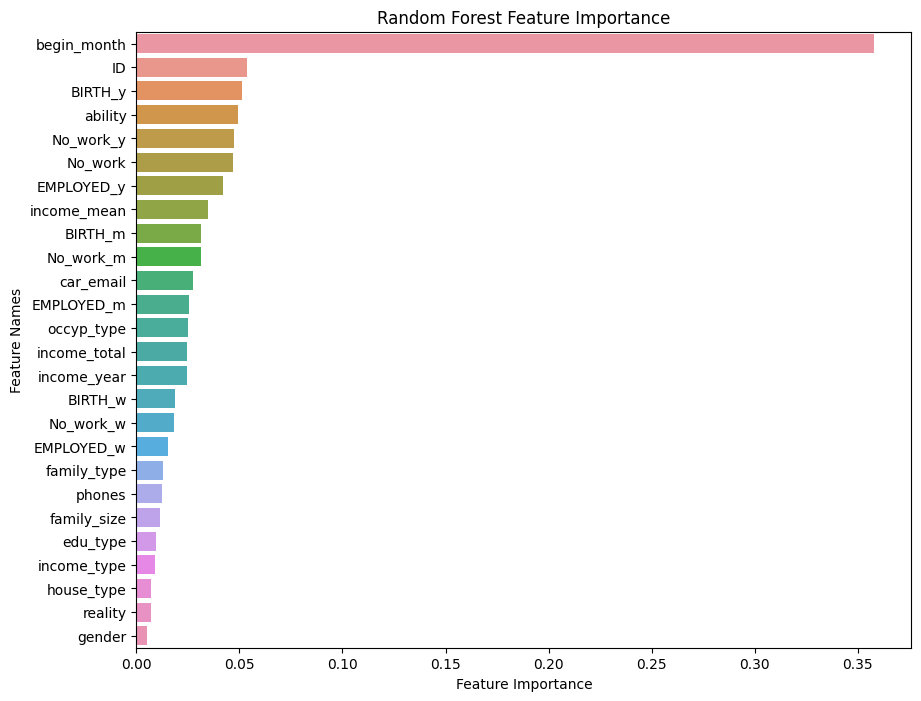

In [ ]:
# 0.7024230095658667
plot_feature_importance(rf_importances,test.columns,'Random Forest')

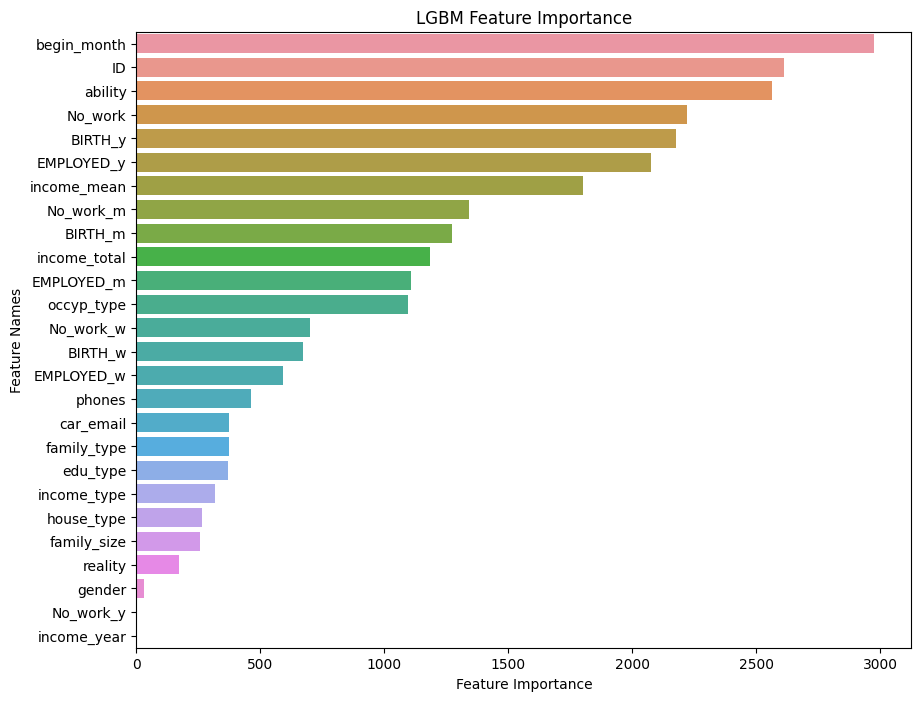

In [ ]:
# 0.7202255630827059 / 7203129900294363
plot_feature_importance(LGBM_importances,test.columns,'LGBM')

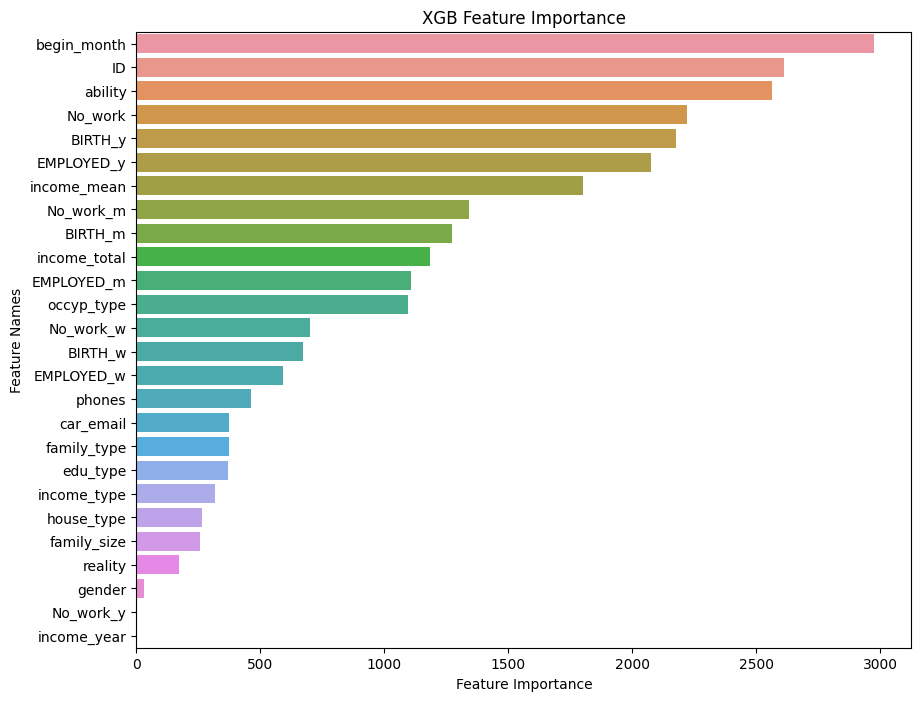

In [ ]:
# 0.7122123050694479
plot_feature_importance(LGBM_importances,test.columns,'XGB')

##### 성능 비교

In [ ]:
base = baseline(train,target)
base

(K_Fold 적용) Trial


  0%|          | 0/8 [00:00<?, ?it/s]

LR 평균 성능 수치 : 0.6413426984855557
SVC 평균 성능 수치 : 0.6413426984855557
KNC 평균 성능 수치 : 0.5415961058818202
RFC 평균 성능 수치 : 0.7058247486818914
CAT 평균 성능 수치 : nan
GBC 평균 성능 수치 : 0.691877391877392
LGBM 평균 성능 수치 : 0.7013644085072658
XGB 평균 성능 수치 : 0.698189469618041


{"LogisticRegression(max_iter=300, multi_class='multinomial', n_jobs=4,\n                   solver='saga') Basic": 0.6413426984855557,
 'SVC(random_state=777) Basic': 0.6413426984855557,
 "KNeighborsClassifier(algorithm='kd_tree', n_jobs=4) Basic": 0.5415961058818202,
 'RandomForestClassifier(n_estimators=300, n_jobs=4, random_state=777) Basic': 0.7058247486818914,
 '<catboost.core.CatBoostRegressor object at 0x7eab81791f00> Basic': nan,
 'GradientBoostingClassifier(n_estimators=300, n_iter_no_change=5,\n                           random_state=777) Basic': 0.691877391877392,
 "LGBMClassifier(n_estimators=300, n_jobs=4, objective='multiclass',\n               random_state=777) Basic": 0.7013644085072658,
 'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              ga

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

# Assuming you have already created and trained the CatBoostRegressor model
model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, l2_leaf_reg=3, subsample=0.8, colsample_bylevel=0.8, random_seed=42, early_stopping_rounds=10,verbose=False)

# Calculate the cross-validated MAE
kfold = 5  # Number of cross-validation folds
mae_scores = cross_val_score(model, train,target, scoring='neg_mean_absolute_error', cv=kfold)

# Convert the negative MAE scores to positive
mae_scores = -mae_scores

# Print the mean MAE and its standard deviation
print("Mean MAE:", mae_scores.mean())
print("MAE Standard Deviation:", mae_scores.std())

Mean MAE: 0.559512738418365
MAE Standard Deviation: 0.005577935758075336


##### cat boost

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

# Assuming you have already created and trained the CatBoostRegressor model
model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, l2_leaf_reg=3, subsample=0.8, colsample_bylevel=0.8, random_seed=42, early_stopping_rounds=10,verbose=False)

# Calculate the cross-validated MAE
kfold = 5  # Number of cross-validation folds
mae_scores = cross_val_score(model, train,target, scoring='neg_mean_absolute_error', cv=kfold)

# Convert the negative MAE scores to positive
mae_scores = -mae_scores

# Print the mean MAE and its standard deviation
print("Mean MAE:", mae_scores.mean())
print("MAE Standard Deviation:", mae_scores.std())

Mean MAE: 0.558141517988878
MAE Standard Deviation: 0.005735500055772106


# ML

### AUTO ML
-<출처> https://velog.io/@otzslayer/MLflow%EC%99%80-Optuna-%EC%9D%B4%EC%9A%A9%ED%95%98%EC%97%AC-%EB%AA%A8%EB%8D%B8-%ED%8A%9C%EB%8B%9D%ED%95%98%EA%B3%A0-%EA%B4%80%EB%A6%AC%ED%95%98%EA%B8%B0

In [ ]:
from typing import List

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# def load_data() -> tuple[pd.DataFrame, np.ndarray]:
#     df = pd.read_csv("./data/train.csv")

#     y = np.log1p(df["SalePrice"].ravel())
#     X = df.drop(["Id", "Alley", "PoolQC", "Fence",
#                 "MiscFeature", "SalePrice"], axis=1)
# return X, y

def identify_column_types(X: pd.DataFrame): #-> tuple[List, List]
    num_cols = X.select_dtypes("number").columns.tolist()
    cat_cols = X.select_dtypes("object").columns.tolist()

    return num_cols, cat_cols

def make_preprocess_pipeline(num_cols, cat_cols): # -> ColumnTransformer
    num_processor = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler",  MinMaxScaler())
    ])

    cat_processor = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",
                                  fill_value="None"))
    ])

    preprocessor = ColumnTransformer([
        ("num", num_processor, num_cols),
        ("cat", cat_processor, cat_cols)
    ])

    return preprocessor

y = df['credit']
X = df.drop('credit', axis = 1)

num_cols, cat_cols = identify_column_types(X)

preprocessor = make_preprocess_pipeline(num_cols, cat_cols)

X_ = pd.DataFrame(preprocessor.fit_transform(X, y),
                  columns=num_cols+cat_cols)

In [ ]:
import catboost
import optuna

class Objective(object):
    def __init__(self, pool):
        self.pool = pool

    def __call__(self, trial):
        pool = self.pool

        max_depth = trial.suggest_int("max_depth", 3, 10)
        learning_rate = trial.suggest_float("learning_rate", 0.05, 0.3)
        subsample = trial.suggest_float("subsample", 0.75, 1)
        l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1e-5, 1e-1, log=True)

        params = {"loss_function": "RMSE",
                "depth": max_depth,
                "learning_rate": learning_rate,
                "subsample": subsample,
                "l2_leaf_reg": l2_leaf_reg}

        cv_result = catboost.cv(pool=pool,
                                params=params,
                                num_boost_round=1000,
                                nfold=5,
                                seed=0,
                                early_stfopping_rounds=30,
                                verbose=False)

        rmsle = cv_result["test-RMSE-mean"].min()

        return rmsle

pool = catboost.Pool(X_, label=y, cat_features=cat_cols)
objective = Objective(pool)

study = optuna.create_study(
    study_name="house_price_prediction",
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(max_resource="auto")
)

[I 2023-08-13 00:56:00,373] A new study created in memory with name: house_price_prediction


#### Web UI 확인
최적화 중, 또는 최적화 완료 후에 mlruns 폴더가 있는 경로에서 다음 명령어를 입력합니다.

 $ mlflow ui
그러면 로컬호스트에 5000번 포트를 통해서 UI 페이지로 접근할 수 있습니다.

 https://127.0.0.1:5000
tracking_uri가 있는 폴더에서 제대로 실행했다면 아래와 같은 UI 페이지를 확인할 수 있습니다.



In [ ]:
%cd

In [ ]:
! mlflow ui

In [ ]:
from optuna.integration.mlflow import MLflowCallback

def make_mlflow_callback():
    cb = MLflowCallback(
         tracking_uri="mlruns",
         metric_name="RMSLE"
    )
    return cb

mlflow_cb = make_mlflow_callback()
study.optimize(objective, n_trials=50, callbacks=[mlflow_cb])

## SCV irls 데이터로 ML

In [ ]:
import os
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import optuna
from optuna.integration.mlflow import MLflowCallback

# iris = load_iris()
# trainx, testx, trainy, testy = train_test_split(iris.data, iris.target, test_size=0.2)
trainx, testx, trainy, testy = train_test_split(train,target,test_size=0.2)

def objective(trial):
    gamma = trial.suggest_loguniform('gamma', 1e-3, 3.0)
    C = trial.suggest_loguniform('C', 1e+0, 1e+2/2)
    kernel = trial.suggest_categorical('kernel', ['linear','rbf','sigmoid'])
    svc = SVC(gamma=gamma, C=C, kernel=kernel)
    svc.fit(trainx, trainy)
    predy = svc.predict(testx)
    accuracy = accuracy_score(testy, predy)
    return accuracy

if __name__=='__main__':

    mlflc = MLflowCallback(tracking_uri='ml_exp',
                      metric_name='accuracy')
    study = optuna.create_study(study_name='iris_test')
    study.optimize(objective, n_trials=50, callbacks=[mlflc])

[I 2023-08-13 00:58:26,490] A new study created in memory with name: iris_test


In [ ]:
def objective(trial):
    gamma = trial.suggest_loguniform('gamma', 1e-3, 3.0)
    C = trial.suggest_loguniform('C', 1e+0, 1e+2/2)
    kernel = trial.suggest_categorical('kernel', ['linear','rbf','sigmoid'])
    svc = SVC(gamma=gamma, C=C, kernel=kernel)
    svc.fit(trainx, trainy)
    predy = svc.predict(testx)
    accuracy = accuracy_score(testy, predy)
    return accuracy

if __name__=='__main__':

    mlflc = MLflowCallback(tracking_uri='ml_exp',
                      metric_name='accuracy')
    study = optuna.create_study(study_name='iris_test')
    study.optimize(objective, n_trials=50, callbacks=[mlflc])

In [ ]:
! mlflow ui --backend-store-uri file:///home/user/dev/mlflowsample/test_optuna/ml_exp/

# 데이콘 1등 피처

In [ ]:
!pip install catboost
!pip install category_encoders

Downloading...
From: https://drive.google.com/uc?id=1F6Otr01l-sUUR_1AdTM925tAGDE_L--t
To: /content/train.csv
100% 3.47M/3.47M [00:00<00:00, 144MB/s]
Downloading...
From: https://drive.google.com/uc?id=13lNIGs3wsD0mZF4OauV4GhZQHniNjK6d
To: /content/test.csv
100% 1.28M/1.28M [00:00<00:00, 84.2MB/s]
Number of Numerical features:  18
Number of Categorical features:  9

----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0346960	test: 1.0333820	best: 1.0333820 (0)	total: 65.4ms	remaining: 1m 5s
100:	learn: 0.7044704	test: 0.6427096	best: 0.6427096 (100)	total: 13.5s	remaining: 2m
200:	learn: 0.6843687	test: 0.6403953	best: 0.6402982 (176)	total: 28.5s	remaining: 1m 53s
300:	learn: 0.6680286	test: 0.6392776	best: 0.6392019 (296)	total: 43.8s	remaining: 1m 41s
400:	learn: 0.6514264	test: 0.6384948	best: 0.6384948 (400)	total: 58.8s	remaining: 1m 27s
500:	learn: 0.6341866	test: 0.6398886	best: 0.6384495 (403)	total: 1m 13s	remaining: 1m 13s
Stopped by overfitt

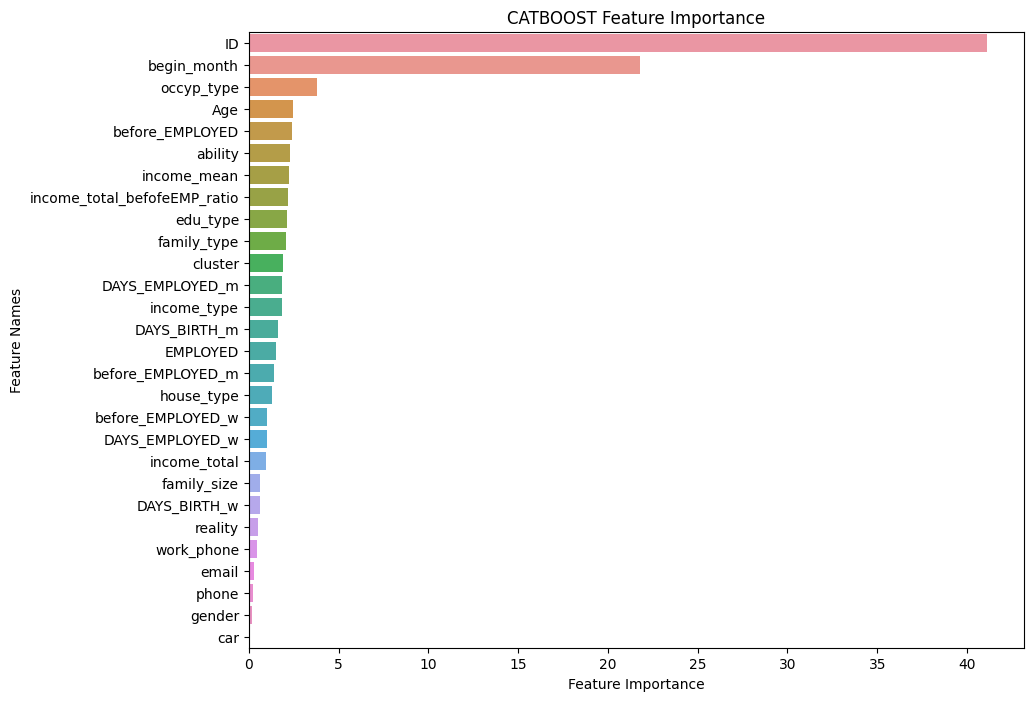

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool
# 데이터 불러오기

!gdown https://drive.google.com/uc?id=1F6Otr01l-sUUR_1AdTM925tAGDE_L--t
!gdown https://drive.google.com/uc?id=13lNIGs3wsD0mZF4OauV4GhZQHniNjK6d

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

# 데이터 전처리
# 1. 결측치 처리

train.fillna('NaN', inplace=True)
test.fillna('NaN', inplace=True)

# 2. 이상치 처리
# train['family_size'] > 7 인 데이터 제거

train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

# Feature Engineering
# 1. 의미없는 변수 제거
# index 제거
# FLAG_MOBIL 삭제:모든 값이 1로 동일

train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

# 2. DAYS_EMPLOYED
# 양수인 데이터는 현재 무직자로 판단, 0 처리

train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

# 3. DAYS_BIRTH, begin_month, DAYS_EMPLOYED
# 음수값 -> 양수 변환

feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

# 4. 파생변수
# numeric 변수는 최대한 다양한 특징을 보일 수 있도록 생성
# category 변수는 여러가지를 조합해 보았지만 전체 변수를 합친 ID 하나만 만들었을때 가장 logloss가 낮았음
# ref) rollcake님 글 https://dacon.io/competitions/official/235713/codeshare/2526?page=1&dtype=recent

for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)


    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])

    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']

    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

# 5. 파생변수와 다중공선을 보이는 컬럼 삭제

cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

# Scaling, Encoding
# 1. Numeric, Category 컬럼 분류

numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

# 2. Log Scale
# income_total

for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

# 3. OrdinalEncoder
# 카테고리 변수는 ordinal_encoder 변환
# ID는 변환 후 정수 처리

encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

# 4. 클러스터링 구성
# 타겟을 결정짓는 뚜렷한 특징을 갖는 피쳐를 찾지 못해 clustering 시도

kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

# 5. StandardScale
# 이미 로그변환을 진행한 income_total을 제외한 나머지 numeric 컬럼 정규화

numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

# Modeling - catboost
# fold 수를 5부터 17까지 돌려보고 최적 fold 15로 판단 후 선택
# parameter를 default로 두는 것이 logloss가 가장 낮았음
# ref) Catboost Documentation - https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html

n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)

  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')
# Feautre Importance
# ID의 중요도가 상당히 높게 나오는 것을 볼 수 있었음
# plot_feature_importance 함수
# ref) https://stackoverflow.com/questions/64988694/how-can-i-get-the-feature-importance-of-a-catboost-in-a-pandas-dataframe

def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [ ]:
test = baseline(X,y)
test

(K_Fold 적용) Trial


  0%|          | 0/7 [00:00<?, ?it/s]

LR 평균 성능 수치 : 0.6412611493140794
SVC 평균 성능 수치 : 0.6412611493140794
KNC 평균 성능 수치 : 0.6354012288227789
RFC 평균 성능 수치 : 0.6994822252289171
GBC 평균 성능 수치 : 0.6941890980832379
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1741
[LightGBM] [Info] Number of data points in the train set: 21160, number of used features: 28
[LightGBM] [Info] Start training from score -2.095448
[LightGBM] [Info] Start training from score -1.443675
[LightGBM] [Info] Start training from score -0.444841
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1741
[LightGBM] [Info] Number of data points in the tra

{"LogisticRegression(max_iter=300, multi_class='multinomial', n_jobs=4,\n                   solver='saga') Basic": 0.6412611493140794,
 'SVC(random_state=777) Basic': 0.6412611493140794,
 "KNeighborsClassifier(algorithm='kd_tree', n_jobs=4) Basic": 0.6354012288227789,
 'RandomForestClassifier(n_estimators=300, n_jobs=4, random_state=777) Basic': 0.6994822252289171,
 'GradientBoostingClassifier(n_estimators=300, n_iter_no_change=5,\n                           random_state=777) Basic': 0.6941890980832379,
 "LGBMClassifier(n_estimators=300, n_jobs=4, objective='multiclass',\n               random_state=777) Basic": 0.7203129900294363,
 'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n         

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=300, random_state=777, n_jobs=4)
LGBM = LGBMClassifier(n_estimators=300, boosting_type='gbdt', learning_rate=0.1, objective='multiclass', random_state=777, n_jobs=4)
XGB = XGBClassifier(verbosity=0, num_parrell_tree=3)

# 모델을 훈련합니다
rf_classifier.fit(X_train, y_train)
LGBM.fit(X_train, y_train)
XGB.fit(X_train, y_train)

# 특성 중요도를 얻습니다
rf_importances = rf_classifier.feature_importances_
rf_feature_names = train.columns

LGBM_importances = LGBM.feature_importances_
LGBM_feature_names = train.columns

XGB_importances = XGB.feature_importances_
XGB_feature_names = train.columns

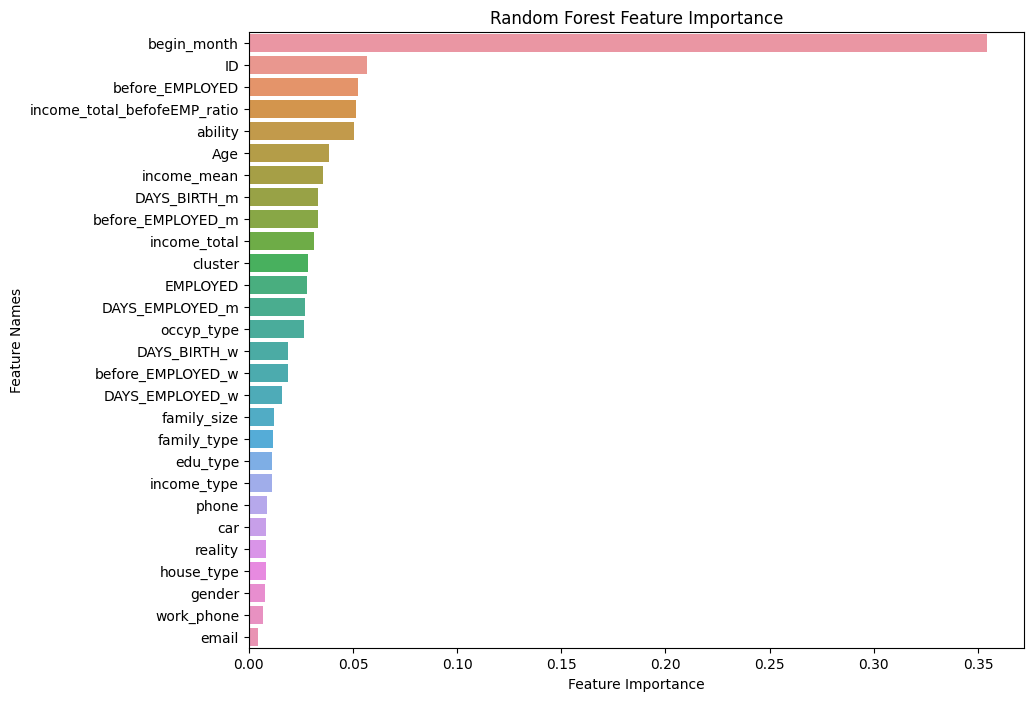

In [ ]:
# 0.6994822252289171
plot_feature_importance(rf_importances,X_test.columns,'Random Forest')

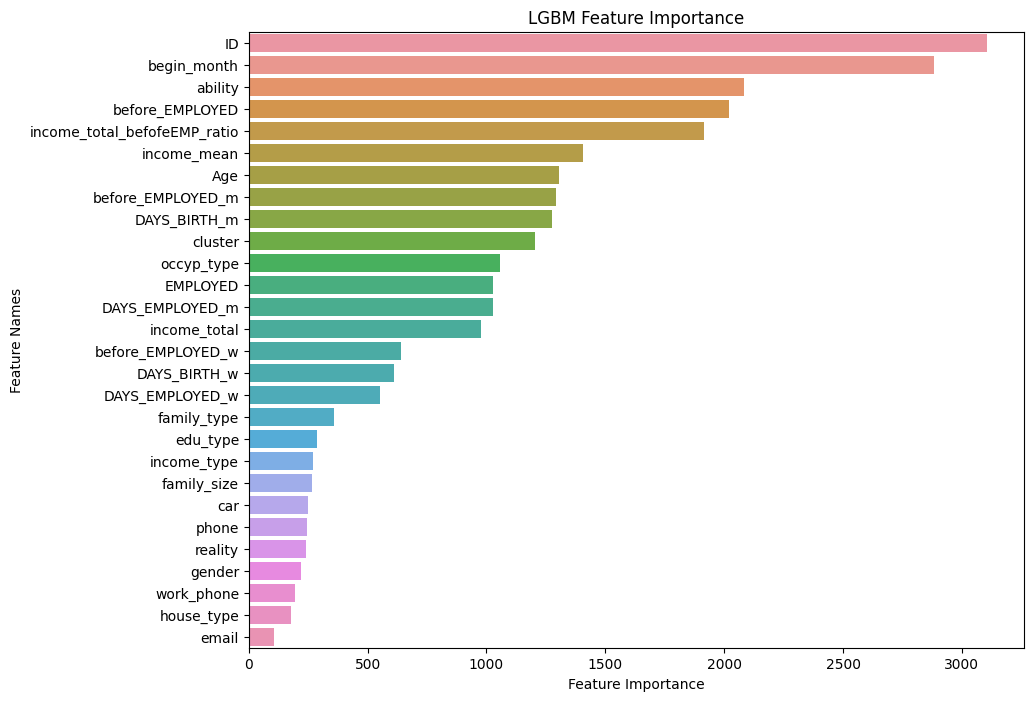

In [ ]:
# 0.7203129900294363
plot_feature_importance(LGBM_importances,X_test.columns,'LGBM')

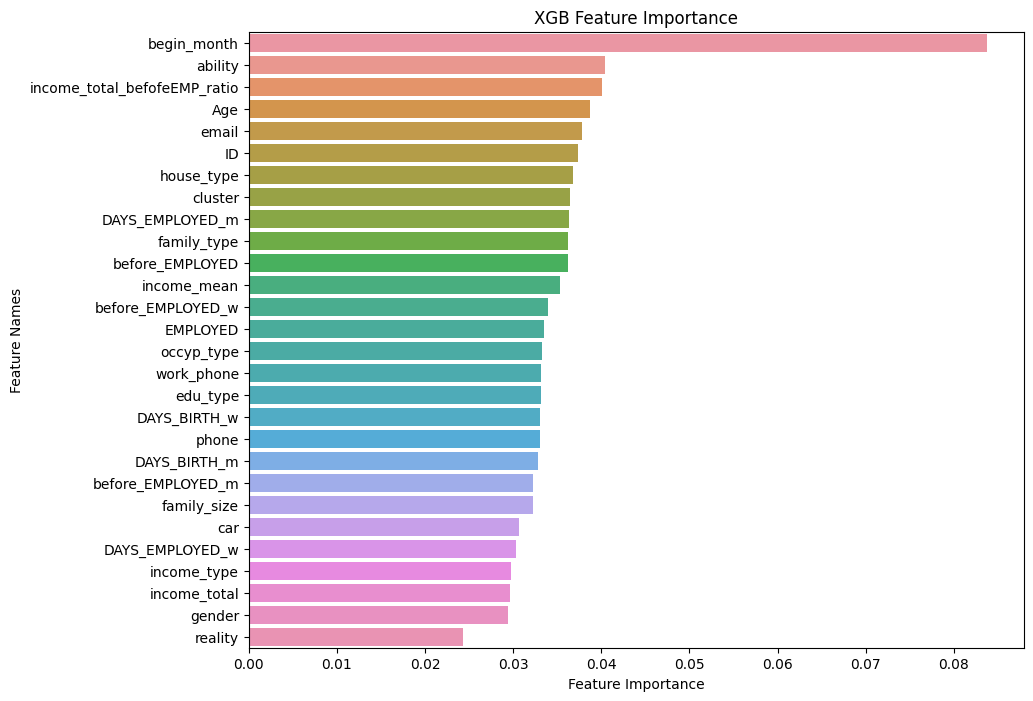

In [ ]:
# 0.7174020727139819
plot_feature_importance(XGB_importances,X_test.columns,'XGB')

# 끝